In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from tqdm import tqdm, trange

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
	from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make('ALE/Freeway-ram-v5')

In [5]:
state, info = env.reset() 

RAM_mask = [14, 16, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]

In [3]:
transition = namedtuple('Transition', ('frames_storage', 'action', 'next_state', 'reward'))

class replay_memory(object): 
	def __init__(self, capacity): 
		self.memory = deque(list(), maxlen=capacity) 
		
	def push(self, *args): 
		self.memory.append(transition(*args))
	
	def sample(self, batch_size): 
		return random.sample(self.memory, batch_size) 
	
	def __len__(self): 
		return len(self.memory) 

In [4]:
def select_action(state): 
	global steps_done 
	sample = random.random() 
	eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1. * steps_done / eps_decay) 
	steps_done += 1 
	if sample > eps_threshold: 
		with torch.no_grad(): 
			return policy_net(torch.from_numpy(np.asarray(state)).float().unsqueeze(0).to(device)).argmax(keepdims=True)
	else: 
		return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def plot_durations(show_result=False): 
	_, ax1 = plt.subplots() 
	durations_t = torch.tensor(episode_duration, dtype=torch.float)
	reward_t = torch.tensor(rewards, dtype=torch.float)
	if show_result: 
		plt.title('Result')
	else: 
		# plt.clf()
		plt.title('Training...')
	ax1.set_xlabel('Episode')
	ax1.set_ylabel('Duration')
	ax1.plot(durations_t.numpy(), color='blue')

	ax2 = ax1.twinx()
	ax2.set_ylabel('Reward')
	ax2.plot(reward_t.numpy(), color='red')

	if is_ipython: 
		if not show_result: 
			display.display(plt.gcf()) 
			display.clear_output(wait=True) 
		else: 
			display.display(plt.gcf())

def optimize_model(): 
	if len(memory) < bs: 
		return False
	transitions = memory.sample(bs)
	batch = transition(*zip(*transitions))
	non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
	non_final_next_states = torch.cat([torch.from_numpy(np.asarray(s)) for s in batch.next_state if s is not None]).view(-1, 4, 210, 160).to(device)
	state_batch = torch.tensor(batch.frames_storage).to(device)
	action_batch = torch.cat(batch.action)
	reward_batch = torch.cat(batch.reward) 

	state_action_values = policy_net(state_batch).gather(1, action_batch) 
	
	next_state_values = torch.zeros(bs, device=device)

	with torch.no_grad(): 
		next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
	
	expected_state_action_values = (next_state_values * gamma) + reward_batch 

	loss = loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

	optimizer.zero_grad() 
	loss.backward() 

	nn.utils.clip_grad_value_(policy_net.parameters(), 100) 
	optimizer.step() 

In [5]:
class dqn(nn.Module): 
	def __init__(self, n_action=env.action_space.n): 
		super().__init__() 

		self.net = nn.Sequential(
			nn.Conv2d(4, 8, 3), nn.ReLU(), nn.MaxPool2d(3), 
			nn.Conv2d(8, 16, 3), nn.ReLU(), nn.MaxPool2d(3), 
			nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(3), 
			nn.Flatten(), nn.Linear(768, 10), nn.ReLU(), 
			nn.Linear(10, n_action)
		)
	
	def forward(self, x): 
		out = self.net(x/255) 
		return out 

# print(torch.from_numpy(np.asarray(frames_storage)).float().shape)
# dqn()(torch.from_numpy(np.asarray(frames_storage)).float().unsqueeze(0))

In [8]:
bs = 128 
gamma = 0.99 
eps_start, eps_end = 0.9, 0.05 
eps_decay = 1000 
tau = 0.005 
lr = 1e-4 

state, info = env.reset() 

policy_net = dqn().to(device) 
target_net = dqn().to(device) 
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
memory = replay_memory(1000000) 

steps_done = 0 

loss_fn = nn.SmoothL1Loss()

num_episodes = 10000000
episode_duration = list() 
rewards, rewards_agg = list(), 0 

state, info = env.reset() 
state = torchvision.transforms.Grayscale()(torch.from_numpy(state).permute(2, 0, 1)).view(210, 160).tolist()
frames_storage = deque([state for _ in range(4)], maxlen=4)
next_state = deque([state for _ in range(4)], maxlen=4)

for i_episode in (loop := trange(num_episodes)): 
	# for t in count(): 
	action = select_action(frames_storage)
	observation, reward, terminated, truncated, _ = env.step(action.item()) 
	# rewards_agg += reward 
	reward = torch.tensor([reward], device=device)

	if terminated: 
		next_state = None 
	else: 
		observation = torchvision.transforms.Grayscale()(torch.from_numpy(observation).permute(2, 0, 1)).view(210, 160).tolist()
		next_state.append(observation)#torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0) 

	memory.push(frames_storage, action, next_state, reward) 

	if not terminated: 
		frames_storage = next_state.copy()

	optimize_model() 

	target_net_state_dict = target_net.state_dict() 
	policy_net_state_dict = policy_net.state_dict() 
	for key in policy_net_state_dict: 
		target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)

	target_net.load_state_dict(target_net_state_dict) 

	if terminated or truncated: 
		# episode_duration.append(t + 1) 
		# plot_durations() 
		state, info = env.reset() 
		state = torchvision.transforms.Grayscale()(torch.from_numpy(state).permute(2, 0, 1)).view(210, 160).tolist()
		frames_storage = deque([state for _ in range(4)], maxlen=4)
		next_state = deque([state for _ in range(4)], maxlen=4)
		# break
	rewards.append(reward.item())
	# plot_durations()
	loop.set_description(f'Iterations {i_episode+1}/{num_episodes}')
	loop.set_postfix(reward=reward.item())

print('Complete')
plot_durations(show_result=True) 
plt.ioff() 
plt.show()

  0%|          | 0/10000000 [00:00<?, ?it/s]

Iterations 7461/10000000:   0%|          | 7461/10000000 [3:48:46<5482:32:00,  1.98s/it, reward=0]

Iterations 7464/10000000:   0%|          | 7464/10000000 [3:48:52<5494:47:29,  1.98s/it, reward=0]

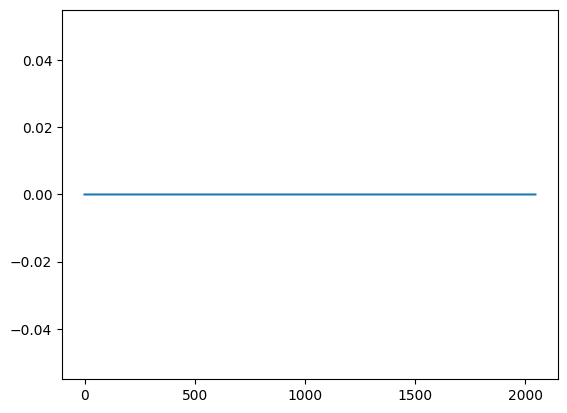

In [7]:
plt.plot(rewards)